In [1]:
import tensorflow as tf
import numpy as np
from keras.applications.vgg16 import VGG16
from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

2024-06-24 13:30:37.415818: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 13:30:38.983099: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (/home/stacy/anaconda3/lib/python3.11/site-packages/keras/api/preprocessing/image/__init__.py)

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [3]:
# Повторення каналів до 3
x_train = np.repeat(x_train[..., np.newaxis], 3, -1)
x_test = np.repeat(x_test[..., np.newaxis], 3, -1)

In [4]:
# Перетворення міток на категоріальний формат
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [5]:
def resize_images(images, labels):
    images = tf.image.resize(images, (150, 150))
    return images, labels

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(resize_images).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(resize_images).batch(32).prefetch(tf.data.experimental.AUTOTUNE)


In [7]:
train_datagen = ImageDataGenerator(
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode="nearest"

)

In [8]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)

In [9]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
vgg16.trainable = False

In [10]:
model = models.Sequential([
    vgg16,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dense(10, activation="softmax"),
])

In [11]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

In [12]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [13]:
history = model.fit(
    train_dataset,
    steps_per_epoch=50,
    epochs=25,
    batch_size=32, 
    validation_data=test_dataset,
    validation_steps=25,
    callbacks=[early_stopping_callback]
)

Epoch 1/25


50/50 [==============================] - 932s 18s/step - loss: 0.9906 - accuracy: 0.6819 - val_loss: 0.5547 - val_accuracy: 0.7912
Epoch 2/25
50/50 [==============================] - 830s 17s/step - loss: 0.5490 - accuracy: 0.7969 - val_loss: 0.4377 - val_accuracy: 0.8425
Epoch 3/25
50/50 [==============================] - 877s 18s/step - loss: 0.4783 - accuracy: 0.8275 - val_loss: 0.3842 - val_accuracy: 0.8587
Epoch 4/25
50/50 [==============================] - 877s 18s/step - loss: 0.4611 - accuracy: 0.8356 - val_loss: 0.3963 - val_accuracy: 0.8575
Epoch 5/25
50/50 [==============================] - 867s 17s/step - loss: 0.4221 - accuracy: 0.8475 - val_loss: 0.3858 - val_accuracy: 0.8625
Epoch 6/25
50/50 [==============================] - 874s 18s/step - loss: 0.4257 - accuracy: 0.8363 - val_loss: 0.3666 - val_accuracy: 0.8700
Epoch 7/25
50/50 [==============================] - 886s 18s/step - loss: 0.4256 - accuracy: 0.8544 - val_loss: 0.4149 - val_accuracy: 0.8487
Epoc

In [14]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Точність на тестовому наборі:', test_acc)

313/313 [==============================] - 3663s 12s/step - loss: 0.3487 - accuracy: 0.8738
Точність на тестовому наборі: 0.8737999796867371


In [15]:
model.save(
"/models/HW10/vgg16_based_model_no_tuning.keras")

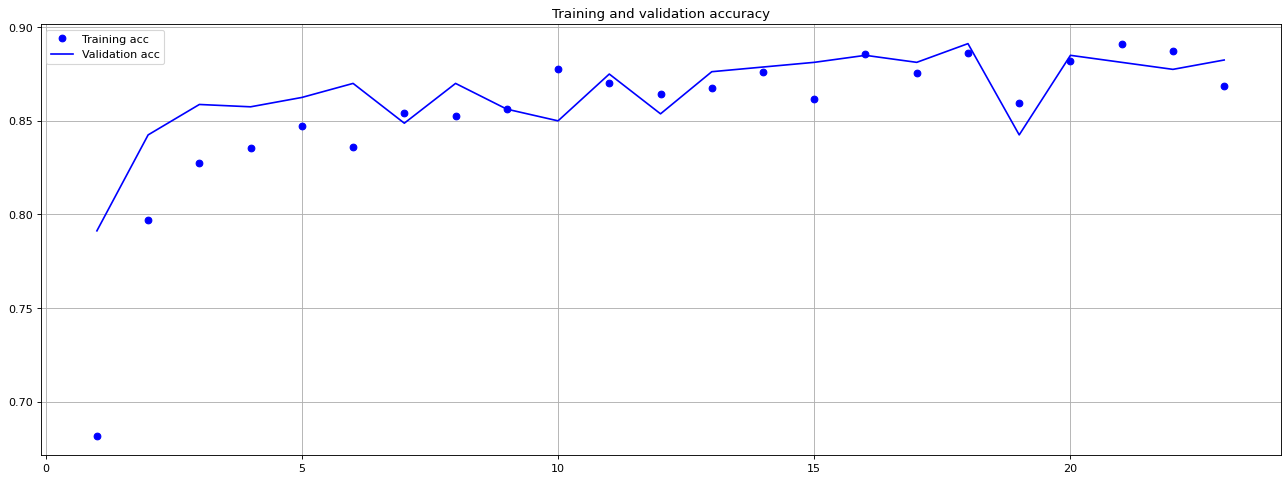

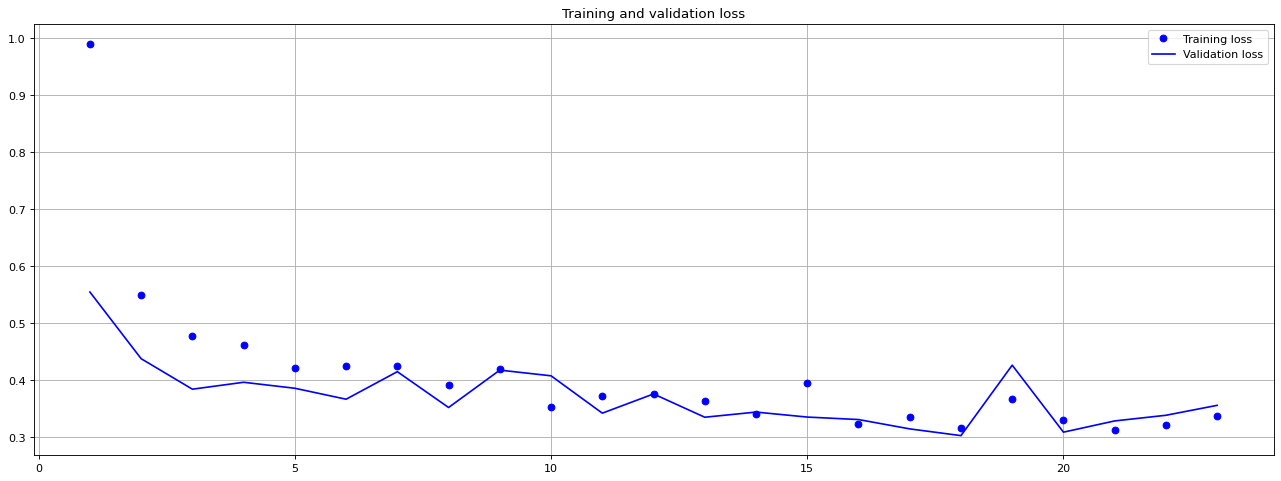

In [16]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss") 
plt.title("Training and validation loss")

plt.legend()
plt.show()

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 16814666 (64.14 MB)
Trainable params: 2099978 (8.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [18]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [19]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
vgg16.trainable = True
set_trainable = False
for layer in vgg16.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


In [20]:
tuned_model = models.Sequential([
    vgg16,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dense(10, activation="softmax"),
])

In [21]:
tuned_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"]
)

In [22]:
history_tuned = tuned_model.fit(
    train_dataset,
    steps_per_epoch=50,
    epochs=25,
    batch_size=32, 
    validation_data=test_dataset,
    validation_steps=25,
    callbacks=[early_stopping_callback]
)

Epoch 1/25
50/50 [==============================] - 925s 18s/step - loss: 1.6299 - accuracy: 0.5231 - val_loss: 0.9878 - val_accuracy: 0.7437
Epoch 2/25
50/50 [==============================] - 915s 18s/step - loss: 0.7172 - accuracy: 0.7819 - val_loss: 0.5508 - val_accuracy: 0.8150
Epoch 3/25
50/50 [==============================] - 900s 18s/step - loss: 0.4904 - accuracy: 0.8275 - val_loss: 0.4613 - val_accuracy: 0.8325
Epoch 4/25
50/50 [==============================] - 914s 18s/step - loss: 0.4510 - accuracy: 0.8388 - val_loss: 0.4314 - val_accuracy: 0.8475
Epoch 5/25
50/50 [==============================] - 909s 18s/step - loss: 0.4371 - accuracy: 0.8481 - val_loss: 0.4006 - val_accuracy: 0.8650
Epoch 6/25
50/50 [==============================] - 901s 18s/step - loss: 0.4141 - accuracy: 0.8456 - val_loss: 0.3696 - val_accuracy: 0.8788
Epoch 7/25
50/50 [==============================] - 901s 18s/step - loss: 0.3668 - accuracy: 0.8694 - val_loss: 0.3612 - val_accuracy: 0.8863
Epoch 

In [23]:
test_loss_tuned, test_acc_tuned = tuned_model.evaluate(test_dataset)
print('Точність на тестовому наборі:', test_acc_tuned)

313/313 [==============================] - 4215s 13s/step - loss: 0.2775 - accuracy: 0.9003
Точність на тестовому наборі: 0.9003000259399414


In [24]:
tuned_model.save(
"/models/HW10/vgg16_based_model_tuned.keras")

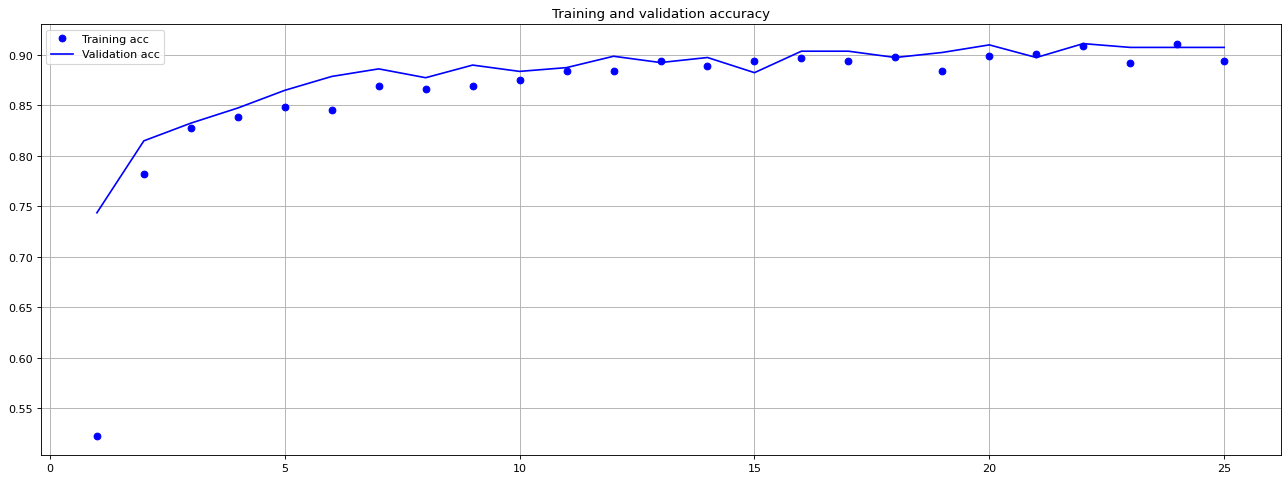

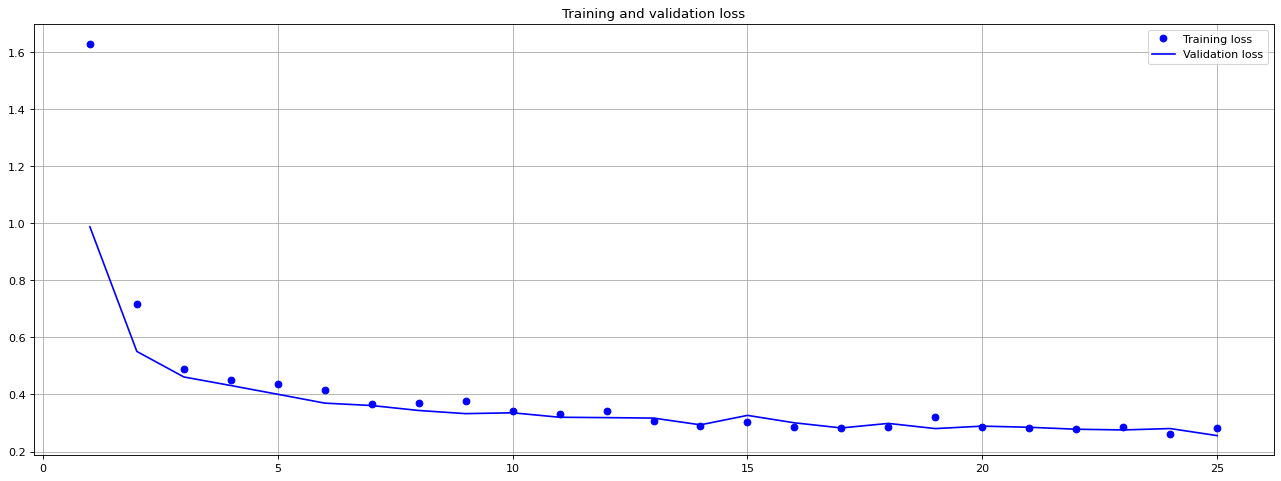

In [25]:
acc_tuned = history_tuned.history["accuracy"]
val_acc_tuned = history_tuned.history["val_accuracy"]

loss_tuned = history_tuned.history["loss"]
val_loss_tuned = history_tuned.history["val_loss"]

epochs_tuned = range(1, len(acc_tuned) + 1)

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs_tuned, acc_tuned, "bo", label="Training acc")
plt.plot(epochs_tuned, val_acc_tuned, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs_tuned, loss_tuned, "bo", label="Training loss")
plt.plot(epochs_tuned, val_loss_tuned, "b", label="Validation loss") 
plt.title("Training and validation loss")

plt.legend()
plt.show()

In [26]:
tuned_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 16814666 (64.14 MB)
Trainable params: 9179402 (35.02 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [27]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

Використання вже готової мережи - потужний інструмент, але вибагливий до hardware, оскільки потребує дуже значного ресурсу на навчання. 

З огляду на те, що система началася локально на компєютері не надто розрахованму на такі задачі, було встановлено обмеження steps_per_epoch=50, що дозволило перевірити працездатність коду.  З цієї ж причини, а також з огляду на обмеженість доступного часу, не вдалося довести точність моделі до рівня, досягнутого в багатошаровій моделі. Але згідно loss-графіков, можливість подальшого донавчання  наявна